In [1]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow import keras

from keras import layers
import os



In [2]:
# Path of my dataset
data_dir = r"E:\\Computer Vision\\Cellula Tech\\Task 1\\Teeth_Dataset"

# Parameter
img_size = (224, 224)   # resize images to this size
batch_size = 32

In [3]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "validation"),
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "test"),
    image_size=img_size,
    batch_size=batch_size
)

num_classes = len(train_ds.class_names)


class_names = train_ds.class_names
print("Class names:", class_names)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


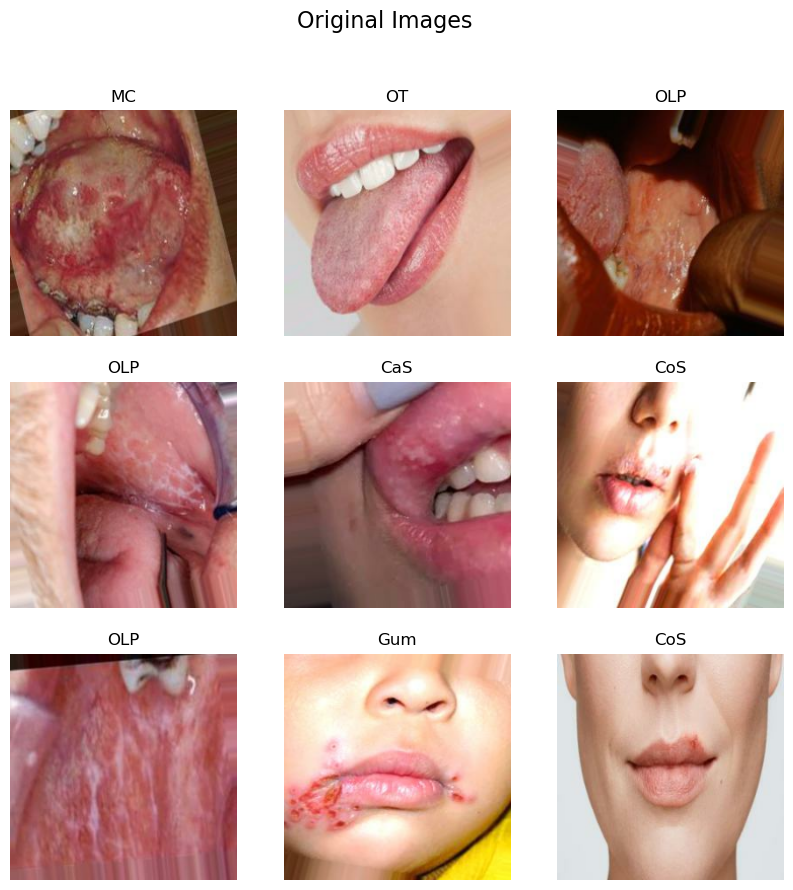

In [10]:
# ✅ 2. Show Original Images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Original Images", fontsize=16)
plt.show()

In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

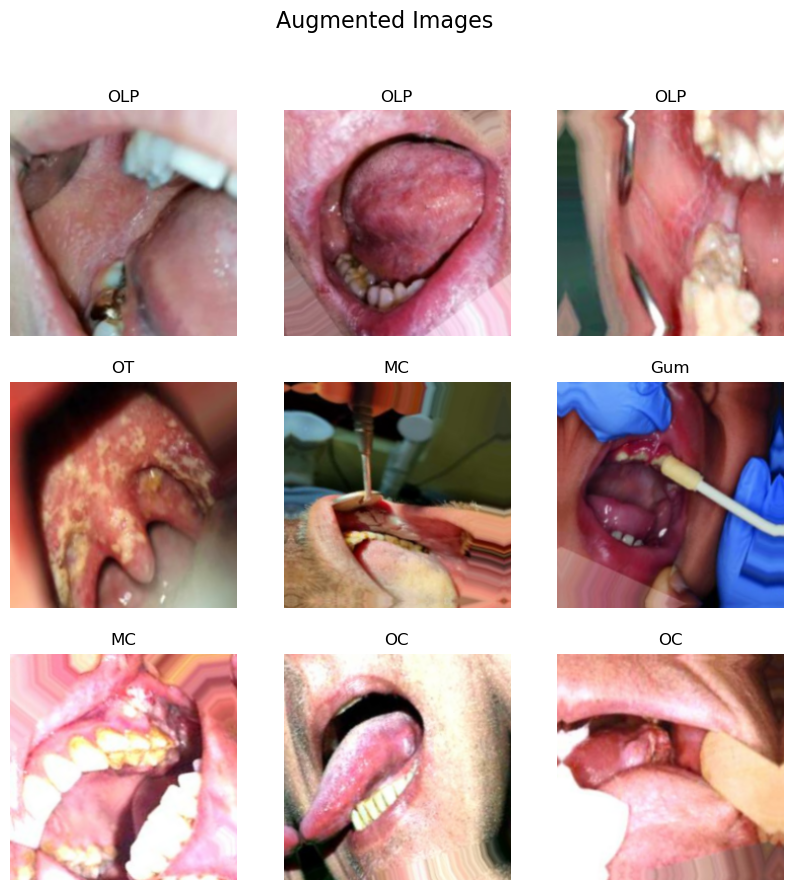

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_img = data_augmentation(images[i])
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img.numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Augmented Images", fontsize=16)
plt.show()

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [6]:
# Normalize images (0-255 → 0-1)
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [164]:
inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)

# Block 1
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)  # 224 -> 112

# Block 2
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)  # 112 -> 56

# Block 3
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)  # 56 -> 28

# Block 4
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)  # 28 -> 14

# Block 5
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
# NO MaxPooling here, keep spatial dimensions 14x14

# Block 6
x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
# Still no MaxPooling

# Flatten and dense
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)


model = keras.Model(inputs=inputs, outputs=outputs)



In [165]:
model.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_378 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_283               │ (None, 112, 112, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_379 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_284               │ (None, 56, 56, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_380 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_285               │ (None, 28, 28, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_381 (Conv2D)             │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_286               │ (None, 14, 14, 256)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_382 (Conv2D)             │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_383 (Conv2D)             │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_384 (Conv2D)             │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_385 (Conv2D)             │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,374,791 (20.50 MB)

 Trainable params: 5,374,791 (20.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",      
    patience=3,              
    restore_best_weights=True  
)


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "teeth_classification_model.h5",         
    monitor="val_loss",      
    save_best_only=True,     
    verbose=1
)


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,   
    patience=2,    
    verbose=1
)


In [169]:
class PrintEpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"✅ Finished epoch {epoch+1}, loss={logs['loss']:.4f}, acc={logs['accuracy']:.4f}")


In [170]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [171]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint, reduce_lr, PrintEpochCallback()]
)



Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.1540 - loss: 1.9373
Epoch 1: val_loss improved from None to 1.79064, saving model to best_model.h5


✅ Finished epoch 1, loss=1.9164, acc=0.1821
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 526ms/step - accuracy: 0.1821 - loss: 1.9164 - val_accuracy: 0.2656 - val_loss: 1.7906 - learning_rate: 1.0000e-04
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.2295 - loss: 1.8492
Epoch 2: val_loss improved from 1.79064 to 1.69604, saving model to best_model.h5


✅ Finished epoch 2, loss=1.8112, acc=0.2485
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 525ms/step - accuracy: 0.2485 - loss: 1.8112 - val_accuracy: 0.2957 - val_loss: 1.6960 - learning_rate: 1.0000e-04
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.2880 - loss: 1.7550
Epoch 3: val_loss did not improve from 1.69604
✅ Finished epoch 3, loss=1.7644, acc=0.2864
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 519ms/step - accuracy: 0.2864 - loss: 1.7644 - val_accuracy: 0.2811 - val_loss: 1.8066 - learning_rate: 1.0000e-04
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.2835 - loss: 1.7532
Epoch 4: val_loss improved from 1.69604 to 1.66491, saving model to best_model.h5


✅ Finished epoch 4, loss=1.7055, acc=0.3081
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 519ms/step - accuracy: 0.3081 - loss: 1.7055 - val_accuracy: 0.3161 - val_loss: 1.6649 - learning_rate: 1.0000e-04
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.3089 - loss: 1.6607
Epoch 5: val_loss improved from 1.66491 to 1.58347, saving model to best_model.h5


✅ Finished epoch 5, loss=1.6391, acc=0.3291
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 531ms/step - accuracy: 0.3291 - loss: 1.6391 - val_accuracy: 0.3706 - val_loss: 1.5835 - learning_rate: 1.0000e-04
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.3486 - loss: 1.6012
Epoch 6: val_loss improved from 1.58347 to 1.58078, saving model to best_model.h5


✅ Finished epoch 6, loss=1.6124, acc=0.3437
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 533ms/step - accuracy: 0.3437 - loss: 1.6124 - val_accuracy: 0.3434 - val_loss: 1.5808 - learning_rate: 1.0000e-04
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.3794 - loss: 1.5536
Epoch 7: val_loss improved from 1.58078 to 1.51457, saving model to best_model.h5


✅ Finished epoch 7, loss=1.5579, acc=0.3810
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 546ms/step - accuracy: 0.3810 - loss: 1.5579 - val_accuracy: 0.3881 - val_loss: 1.5146 - learning_rate: 1.0000e-04
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.3867 - loss: 1.5112
Epoch 8: val_loss improved from 1.51457 to 1.45768, saving model to best_model.h5


✅ Finished epoch 8, loss=1.5456, acc=0.3790
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step - accuracy: 0.3790 - loss: 1.5456 - val_accuracy: 0.3949 - val_loss: 1.4577 - learning_rate: 1.0000e-04
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.4003 - loss: 1.4852
Epoch 9: val_loss improved from 1.45768 to 1.41678, saving model to best_model.h5


✅ Finished epoch 9, loss=1.4913, acc=0.3994
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 558ms/step - accuracy: 0.3994 - loss: 1.4913 - val_accuracy: 0.4300 - val_loss: 1.4168 - learning_rate: 1.0000e-04
Epoch 10/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.4336 - loss: 1.4309
Epoch 10: val_loss did not improve from 1.41678
✅ Finished epoch 10, loss=1.4635, acc=0.4176
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 550ms/step - accuracy: 0.4176 - loss: 1.4635 - val_accuracy: 0.4319 - val_loss: 1.4831 - learning_rate: 1.0000e-04
Epoch 11/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.4290 - loss: 1.4609
Epoch 11: val_loss improved from 1.41678 to 1.40669, saving model to best_model.h5


✅ Finished epoch 11, loss=1.4306, acc=0.4334
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 552ms/step - accuracy: 0.4334 - loss: 1.4306 - val_accuracy: 0.4611 - val_loss: 1.4067 - learning_rate: 1.0000e-04
Epoch 12/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.4430 - loss: 1.4025
Epoch 12: val_loss improved from 1.40669 to 1.39806, saving model to best_model.h5


✅ Finished epoch 12, loss=1.3679, acc=0.4610
97/97 ━━━━━━━━━━━━━━━━━━━━ 58s 592ms/step - accuracy: 0.4610 - loss: 1.3679 - val_accuracy: 0.4465 - val_loss: 1.3981 - learning_rate: 1.0000e-04
Epoch 13/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.4752 - loss: 1.3466
Epoch 13: val_loss improved from 1.39806 to 1.29696, saving model to best_model.h5


✅ Finished epoch 13, loss=1.3412, acc=0.4691
97/97 ━━━━━━━━━━━━━━━━━━━━ 56s 574ms/step - accuracy: 0.4691 - loss: 1.3412 - val_accuracy: 0.4961 - val_loss: 1.2970 - learning_rate: 1.0000e-04
Epoch 14/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.4962 - loss: 1.2886
Epoch 14: val_loss did not improve from 1.29696
✅ Finished epoch 14, loss=1.2845, acc=0.5031
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 558ms/step - accuracy: 0.5031 - loss: 1.2845 - val_accuracy: 0.4679 - val_loss: 1.3554 - learning_rate: 1.0000e-04
Epoch 15/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.5106 - loss: 1.3018
Epoch 15: val_loss improved from 1.29696 to 1.26394, saving model to best_model.h5


✅ Finished epoch 15, loss=1.2795, acc=0.5115
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 558ms/step - accuracy: 0.5115 - loss: 1.2795 - val_accuracy: 0.5058 - val_loss: 1.2639 - learning_rate: 1.0000e-04
Epoch 16/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5252 - loss: 1.2244
Epoch 16: val_loss improved from 1.26394 to 1.18556, saving model to best_model.h5


✅ Finished epoch 16, loss=1.2051, acc=0.5403
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 582ms/step - accuracy: 0.5403 - loss: 1.2051 - val_accuracy: 0.5535 - val_loss: 1.1856 - learning_rate: 1.0000e-04
Epoch 17/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.5646 - loss: 1.1596
Epoch 17: val_loss did not improve from 1.18556
✅ Finished epoch 17, loss=1.1801, acc=0.5462
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 563ms/step - accuracy: 0.5462 - loss: 1.1801 - val_accuracy: 0.5224 - val_loss: 1.2250 - learning_rate: 1.0000e-04
Epoch 18/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.5833 - loss: 1.1168
Epoch 18: val_loss improved from 1.18556 to 1.14164, saving model to best_model.h5


✅ Finished epoch 18, loss=1.1173, acc=0.5850
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 539ms/step - accuracy: 0.5850 - loss: 1.1173 - val_accuracy: 0.5827 - val_loss: 1.1416 - learning_rate: 1.0000e-04
Epoch 19/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.6205 - loss: 1.0493
Epoch 19: val_loss improved from 1.14164 to 0.98334, saving model to best_model.h5


✅ Finished epoch 19, loss=1.0506, acc=0.6067
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 527ms/step - accuracy: 0.6067 - loss: 1.0506 - val_accuracy: 0.6070 - val_loss: 0.9833 - learning_rate: 1.0000e-04
Epoch 20/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6089 - loss: 1.0170
Epoch 20: val_loss improved from 0.98334 to 0.92802, saving model to best_model.h5


✅ Finished epoch 20, loss=1.0152, acc=0.6207
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 530ms/step - accuracy: 0.6207 - loss: 1.0152 - val_accuracy: 0.6459 - val_loss: 0.9280 - learning_rate: 1.0000e-04
Epoch 21/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.6573 - loss: 0.9616
Epoch 21: val_loss did not improve from 0.92802
✅ Finished epoch 21, loss=0.9520, acc=0.6537
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 529ms/step - accuracy: 0.6537 - loss: 0.9520 - val_accuracy: 0.6479 - val_loss: 0.9411 - learning_rate: 1.0000e-04
Epoch 22/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.6762 - loss: 0.8658
Epoch 22: val_loss improved from 0.92802 to 0.92052, saving model to best_model.h5


✅ Finished epoch 22, loss=0.8937, acc=0.6696
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 517ms/step - accuracy: 0.6696 - loss: 0.8937 - val_accuracy: 0.6381 - val_loss: 0.9205 - learning_rate: 1.0000e-04
Epoch 23/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6854 - loss: 0.8480
Epoch 23: val_loss did not improve from 0.92052
✅ Finished epoch 23, loss=0.8496, acc=0.6926
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 521ms/step - accuracy: 0.6926 - loss: 0.8496 - val_accuracy: 0.6449 - val_loss: 0.9597 - learning_rate: 1.0000e-04
Epoch 24/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7184 - loss: 0.7821
Epoch 24: val_loss improved from 0.92052 to 0.84152, saving model to best_model.h5


✅ Finished epoch 24, loss=0.8142, acc=0.7033
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 522ms/step - accuracy: 0.7033 - loss: 0.8142 - val_accuracy: 0.6790 - val_loss: 0.8415 - learning_rate: 1.0000e-04
Epoch 25/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7178 - loss: 0.7729
Epoch 25: val_loss improved from 0.84152 to 0.76415, saving model to best_model.h5


✅ Finished epoch 25, loss=0.7673, acc=0.7208
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 519ms/step - accuracy: 0.7208 - loss: 0.7673 - val_accuracy: 0.7072 - val_loss: 0.7641 - learning_rate: 1.0000e-04
Epoch 26/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7106 - loss: 0.7926
Epoch 26: val_loss improved from 0.76415 to 0.71530, saving model to best_model.h5


✅ Finished epoch 26, loss=0.7729, acc=0.7169
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 518ms/step - accuracy: 0.7169 - loss: 0.7729 - val_accuracy: 0.7422 - val_loss: 0.7153 - learning_rate: 1.0000e-04
Epoch 27/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7266 - loss: 0.7215
Epoch 27: val_loss did not improve from 0.71530
✅ Finished epoch 27, loss=0.7452, acc=0.7292
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 514ms/step - accuracy: 0.7292 - loss: 0.7452 - val_accuracy: 0.7344 - val_loss: 0.7569 - learning_rate: 1.0000e-04
Epoch 28/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7714 - loss: 0.6449
Epoch 28: val_loss improved from 0.71530 to 0.63724, saving model to best_model.h5


✅ Finished epoch 28, loss=0.6291, acc=0.7775
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 516ms/step - accuracy: 0.7775 - loss: 0.6291 - val_accuracy: 0.7646 - val_loss: 0.6372 - learning_rate: 1.0000e-04
Epoch 29/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7611 - loss: 0.6281
Epoch 29: val_loss improved from 0.63724 to 0.54889, saving model to best_model.h5


✅ Finished epoch 29, loss=0.6511, acc=0.7603
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 521ms/step - accuracy: 0.7603 - loss: 0.6511 - val_accuracy: 0.8054 - val_loss: 0.5489 - learning_rate: 1.0000e-04
Epoch 30/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8052 - loss: 0.5485
Epoch 30: val_loss did not improve from 0.54889
✅ Finished epoch 30, loss=0.5561, acc=0.7992
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 521ms/step - accuracy: 0.7992 - loss: 0.5561 - val_accuracy: 0.7549 - val_loss: 0.6850 - learning_rate: 1.0000e-04
Epoch 31/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7935 - loss: 0.5897
Epoch 31: val_loss improved from 0.54889 to 0.45155, saving model to best_model.h5


✅ Finished epoch 31, loss=0.5396, acc=0.8086
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 523ms/step - accuracy: 0.8086 - loss: 0.5396 - val_accuracy: 0.8220 - val_loss: 0.4516 - learning_rate: 1.0000e-04
Epoch 32/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.7941 - loss: 0.5633
Epoch 32: val_loss did not improve from 0.45155
✅ Finished epoch 32, loss=0.5731, acc=0.7881
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 521ms/step - accuracy: 0.7881 - loss: 0.5731 - val_accuracy: 0.7918 - val_loss: 0.5861 - learning_rate: 1.0000e-04
Epoch 33/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8385 - loss: 0.4626
Epoch 33: val_loss did not improve from 0.45155

Epoch 33: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
✅ Finished epoch 33, loss=0.4992, acc=0.8215
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 533ms/step - accuracy: 0.8215 - loss: 0.4992 - val_accuracy: 0.7802 - val_loss: 0.5951 - learning_rate: 1.0000e-04
Epoch 34/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8430 - loss:

In [176]:
model.save("teeth_classification_model.h5")
print("Model saved as teeth_classification_model.h5")

Model saved as teeth_classification_model.h5


In [177]:
model.save("teeth_classification_model.keras")
print("Model saved as teeth_classification_model.keras")


Model saved as teeth_classification_model.keras


In [178]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8414 - loss: 0.4624
Test Accuracy: 0.8414396643638611


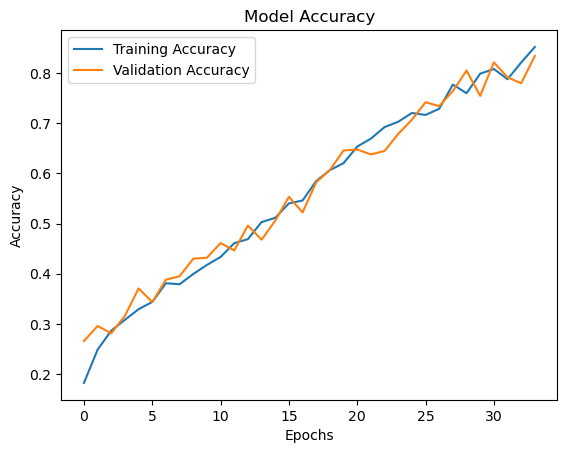

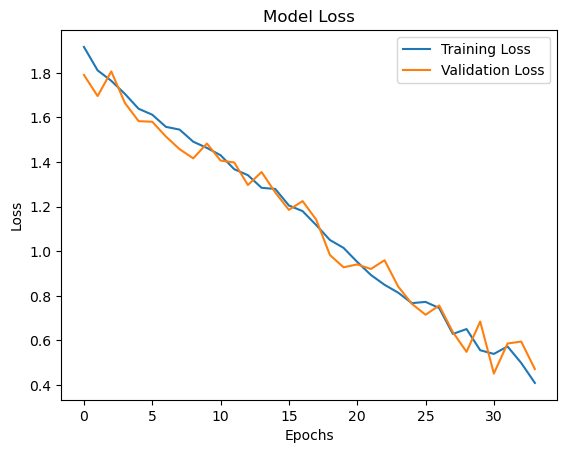

In [179]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()